In [3]:
main_path = "./model_files/"

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()  # Loads from .env file by default

openai_key = os.getenv("OPENAI_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")


In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="phi-4-IQ4_XS",
    temperature=0.6,
    base_url="http://localhost:8000/v1"
)

reasoning_llm = ChatOpenAI(
    model="phi-4-IQ4_XS",
    temperature=0.6,
    base_url="http://localhost:8000/v1"
)

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="sentence-transformers/all-MiniLM-L6-v2",
    force_download=True
)

/home/kefal/miniconda3/envs/mi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 30 files: 100%|██████████| 30/30 [00:04<00:00,  6.86it/s]


'/home/kefal/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf'

In [2]:
from langchain_core.documents import Document
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

pdfs_path = "./model_downloaded_pdfs/"
# 1. Create your documents
loader = PyMuPDFLoader(pdfs_path+"1311.0635v2.pdf")
docs = loader.load()

# 2. Load local embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs={"device":"cpu"})

# 3. Create the FAISS vector store
vector_store = FAISS.from_documents(docs, embeddings)



/tmp/ipykernel_3845/3062909178.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs={"device":"cpu"})
/home/kefal/miniconda3/envs/mi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 4. Run a similarity search
query = "Tell me about entanglement"
results = vector_store.similarity_search(query, k=2)

# 5. Print results
for i, doc in enumerate(results):
    print(f"\nResult {i+1}:")
    print("Content:", doc.page_content)
    print("Metadata:", doc.metadata)


NameError: name 'vector_store' is not defined

In [28]:
# 4. Run a similarity search
query = "Results"
results = vector_store.similarity_search(query, k=2)

# 5. Print results
for i, doc in enumerate(results):
    print(f"\nResult {i+1}:")
    print("Content:", doc.page_content)
    print("Metadata:", doc.metadata)


Result 1:
Content: microns to guide atoms from a thermal source by a red- or blue-detuned optical dipole
trap [19–24]. However, capillaries suﬀer easily from transverse multi-mode operation of the
guiding ﬁeld, attenuation of the beam while it propagates along the capillary, as well as
the formation of speckles [19, 24], which are all detrimental to guiding of atoms. With the
availability of hollow-core photonic crystal ﬁbers (HCPCFs) [25], also low-loss, single-mode
guiding of light in hollow ﬁbers became possible. Since then, several groups demonstrated
guiding of atoms into [26–28] or through HCPCFs [29, 30]. In these experiments the source of
atoms was either a thermal oven [29], laser-cooled atoms from a magneto-optical trap (MOT)
[27, 28, 30], or even a Bose-Einstein condensate [26]. Apart from the latter, technically very
challenging approach, the most successful preparation of a medium at large OD so far was
reported by Bajcsy et al. [28]. The authors demonstrated the loading 

In [3]:
from phi_delta.memory.memory import AgentMemory

memory = AgentMemory()


In [49]:
import arxiv
from langchain.tools import Tool

# 2. Create a custom function that returns structured data

def search_arxiv_details(query: str, download= False, max_results: int = 3) -> str:

    memory.arxiv_links.clear()

    """
    Searches arXiv for a given query and returns a formatted string with
    the paper's title, summary, arXiv ID, and a direct link.
    """
    try:
    
        # Perform the search using the arxiv library
        Client = arxiv.Client()

        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.Relevance
        )

        formatted_results = []
        for result in Client.results(search):
            # The entry_id is the full URL, we can use it directly as the link
            paper_link = result.entry_id
            # The actual ID is the last part of the URL
            paper_id = paper_link.split('/')[-1]

            result_string = (
                f"Title: {result.title}\n"
                f"Authors: {', '.join(author.name for author in result.authors)}\n"
                f"Published: {result.published.strftime('%Y-%m-%d')}\n"
                f"Summary: {result.summary}\n"
                f"ArXiv ID: {paper_id}\n"
                f"Link: {paper_link}\n"
            )
            formatted_results.append(result_string)
            
            
            memory.arxiv_links.append([paper_link, result.title])

        if not formatted_results:
            return "No results found on ArXiv for that query."

        if not download:
            return "\n---\n".join(formatted_results)

        return "\n---\n".join(formatted_results)

    except Exception as e:
        print("error")
        return f"An error occurred during ArXiv search: {e}"

def search_arxiv_tool_input(input_data: dict) -> str:
    query = input_data.get("query", "")
    max_results = input_data.get("max_results", 3)

    return search_arxiv_details(query=query, max_results=max_results)


In [50]:
import requests
from pathlib import Path
from typing import List, Tuple

def download_arxiv_pdfs(links: List[str], save_directory: str = main_path) -> Tuple[str, List[str]]:
    downloaded_file_paths = []

    def convert_to_pdf_url(url: str) -> str:
        if "arxiv.org/abs/" in url:
            return url.replace("/abs/", "/pdf/") + ".pdf"
        elif "arxiv.org/pdf/" in url and not url.endswith(".pdf"):
            return url + ".pdf"
        return url

    Path(save_directory).mkdir(parents=True, exist_ok=True)

    for arxiv_url,doc_name in links:
        
        pdf_url = convert_to_pdf_url(arxiv_url)

        # Better Document Names
        doc_name = doc_name.replace(" ", "_").replace("/","-") + ".pdf"

        filepath = Path(save_directory) / doc_name 

        try:
            response = requests.get(pdf_url)
            response.raise_for_status()
            with open(filepath, "wb") as f:
                f.write(response.content)
            print(f"✅ Downloaded to: {filepath}")
            downloaded_file_paths.append(str(filepath))
        except Exception as e:
            print(f"❌ Failed to download {pdf_url}: {e}")

    summary_msg = f"Successfully downloaded {len(downloaded_file_paths)} PDFs."
    return summary_msg, downloaded_file_paths



In [51]:
def list_directory(filetype: str = None, directory: str = main_path) -> list[str]:
    import os
    try:
        files = os.listdir(directory)
        if filetype:
            return sorted([f for f in files if f.endswith(filetype)])
        return sorted(files)
    except Exception as e:
        return [f"Error listing directory: {e}"]

def list_files_tool_wrapper(input: str = ""):
    filetype = input.strip() or None
    return list_directory(filetype=filetype)


In [52]:
from langchain_community.tools import TavilySearchResults
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain_community.utilities import ArxivAPIWrapper
from langchain.tools import Tool
from langchain.agents import load_tools
from langchain.tools import StructuredTool

import phi4multimodal

search_tool = TavilySearchResults(max_results = 5, include_answer = True)
code_tool = PythonREPLTool()
multimodal_tool = phi4multimodal.Phi4MMTool()

#arxiv = ArxivAPIWrapper(top_k_results=3)

arxiv_tool = StructuredTool.from_function(
    name="arxiv_search",
    func=search_arxiv_tool_input,
    description=(
        "Searches ArXiv for academic papers. "
        "Accepts a dictionary with 'query' (str), and 'max_results' (int). "
        "Example input: {'query': 'quantum entanglement', 'max_results': 5}"
    )
)

download_tool = Tool.from_function(
    name="download_arxiv_pdfs",
    func=lambda _: download_arxiv_pdfs(memory.arxiv_links),  # return just the message
    description="Downloads the PDF versions of academic papers from the last arxiv_search. It saves them locally for extensive analysis of the academic resources."
)


list_files_tool = Tool.from_function(
    name="list_files",
    func=list_files_tool_wrapper,
    description="Lists files in the directory. Optionally filter by file extension like 'pdf'."
)

tools = [search_tool, code_tool, multimodal_tool, arxiv_tool, download_tool, list_files_tool]

In [53]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model = llm,
    tools = tools,
)

In [54]:
def extract_tool_names(conversation:dict) -> list[str]:
    tool_names = set()
    for msg in conversation.get('messages', []):
        calls = []
        if hasattr(msg, 'tool_calls'):
            calls = msg.tool_calls or []
        elif isinstance(msg,dict):
            calls = msg.get('tool_calls') or []
            if not calls and isinstance(msg.get('additional_kwargs'), dict):
                calls = msg['additional_kwargs'].get('tool_calls', [])
        else:
            ak = getattr(msg, 'additional_kwargs', None)
            if isinstance(ak, dict):
                calls = ak.get('tool_calls', [])
        for call in calls:
            if isinstance(call, dict):
                if 'name' in call:
                    tool_names.add(call['name'])
                elif 'function' in call and isinstance(call['function'], dict):
                    fn = call['function']
                    if 'name' in fn:
                        tool_names.add(fn['name'])
    return sorted(tool_names)

In [55]:
conv_hist = summarize_conversation(memory.chat_history)

In [44]:
print(type(conv_hist))

<class 'str'>


In [16]:
import phi_delta.agents.router as router



In [26]:
print(router.run_router(reasoning_llm,"i will kill myself",""))

Router Prompt: 
    
You are a router agent. Your job is to classify the query into one of two pipelines.

You MUST choose exactly one of the following options. Do not explain your choice. Do not output anything else.

Since the user can ask questions back to back, there might be some context available here from the older messages and actions that relates to the users message: 

---

**Available Pipelines:**

1) QuickResponse  
Use this if the query is a simple or casual question, such as "How are you?", "Who are you?", or other short, conversational, or factual queries that do not require tools or reasoning.

2) Agentic  
Use this if the query is complex, involves reasoning, tool use, analysis, math, or planning. Anything requiring an agentic workflow falls here.

---

**Instructions:**

- Just select the pipeline name.
- DO NOT generate any reasoning, explanation, or steps.
- ONLY output the selected pipeline in the format below:

**Response Format (strict):**

Choosen Pipeline: <Qui

In [ ]:
#yapıldı
TOOL_DESCRIPTIONS = """
You have access to the following tools:

1. search_tool: Use this to search the web for up-to-date information, including breaking news.
   - Input: a natural language query
   - Output: recent web results related to the query

2. arxiv_search: Use this to search for academic papers in a max_results amount. download_tool can be used AFTER to download the resulting PDFs to local storage for further analysis. Downloading the previously accessed ArXiv links are not possible, it has to be downloaded right away or not. 
   - Input: A dictionary. Example: "query":"the topic/author to be searched", "max_results": 3-5 etc.
   - Output: A number of academic papers with summaries, authors, and links. 

3. code_tool: Executes Python code.
   - Input: a Python expression or block
   - Output: the result of code execution (e.g., calculations, data analysis)

4. multimodal_tool: Use this to analyze or interpret images.
   - Input: an image and a prompt (e.g., "Describe this image.")
   - Output: a description or interpretation of the image

5. download_tool: Use this to download the previously accessed academic papers with arxiv_search tool. You can ONLY use this tool after you use arxiv_search, and it will only download tha papers you searched exactly before this tool.
   - Input: Simple Run, No Input
   - Output: Downloading the Papers searched before to gather a deep analysis on them.

6. list_directory_tool: Use this to check your directory. You can check out the previous files that are downloaded before you to gather information about their name to further analysis on the next steps.
   - Input: "" for listing ALL files, or "pdf", "jpeg" etc. to filter-search with special file types.
   - Output: The directories of the specified folders

You are only allowed to plan steps that use these tools. Do not mention subscribing to newsletters, downloading apps, or using external social media platforms.

You need to only solve the task. Do not add something suggestive.
"""
#yapıldı 
def run_quickresponse(question: str, context: str = memory.chat_summary):

    quickresponse_prompt = f"""
You are a helpful assistant named "Phi Delta" that is aimed to help researchers and curious people about their tasks. You have a variety of tools that you can use, and your main goal is to help the user as much as possible in a positive way. You can answer questions about daily life and basic questions.

Since the user can ask questions back to back, there might be some context available here from the older messages and actions that relates to the users message: {context}
"""

    result = reasoning_llm.invoke([

        {"role": "system", "content": quickresponse_prompt},
        {"role": "user", "content": f"Task: {question}"}

    ])
    return result.content

#yapıldı
def run_planner(question: str, context: str = memory.chat_summary):

    planner_prompt = f"""
You are a planning agent. Break the task given from the user into high-qualityclear, tool-usable small number of steps (usually 3–7) that an autonomous agent can follow in sequence. Don't proceed with the steps. Refer to the tools when you think its logical to do. 

To make more sense of the users input, there might be context available here: {context}

Your Tools:
"""

    result = reasoning_llm.invoke([

        {"role": "system", "content": planner_prompt + TOOL_DESCRIPTIONS},
        {"role": "user", "content": f"Task: {question}"}

    ])
    return result.content

#yapıldı
def run_critic(planner_response: str, question: str):

    critic_prompt = """
    You are a critic agent responsible for improving plans generated by a planner agent.

    Your task is to:
    - Evaluate a step-by-step plan for a given task
    - Correct any tool misuses, vague steps, or missing logic
    - Rewrite the plan as a clear, numbered list of executable steps
    - Ensure every step refers to an available tool (if needed), and uses it correctly

    **Instructions:**
    1. Use only the following tools: search_tool, arxiv_search, code_tool, multimodal_tool.
    2. If a step involves a tool, specify it clearly with the input it should receive.
    3. Do not invent tools or external services.
    4. Be concise, logical, and tool-aware.
    5. Return your output in the structured format below.

    **Response Format:**

    Corrected Plan:
    Step 1. <Step 1>
    Step 2. <Step 2>
    ...

    Verdict: <READY or REVISE>

    Only output the plan and verdict in the format shown above. You have tools that can be used: 
    """

    result = reasoning_llm.invoke([

        {"role": "system", "content": critic_prompt + TOOL_DESCRIPTIONS},
        {"role": "user", "content": f"Planner Agent's Response: {planner_response}"}

    ])
    return result.content

## yapıldı
def run_agent(step: str, context: str = memory.chat_summary):


    executor_prompt = f"""
    You are a step-by-step execution agent.

    Your job is to perform the following step provided by the planner agent.

    - Use tools ONLY if explicitly mentioned.
    - Use the provided context below ONLY if relevant:
    {context}

    ---

    When you are done, respond in **exactly** the format below:

    ---

    ### Summary:
    - You MUST list any names, URLs, locations, files, or outputs you found.
    - Always include **lists** when the step returns a set of results.
    - This summary will be used as memory for future steps. Do NOT skip any critical information.
    - Example:
    ❌ Bad: "I found good options."  
    ✅ Good: "Top results: 1. X, 2. Y, 3. Z."

    If you retrieved data but do not summarize it clearly here, future agents will fail.

    ### Resources:
    List all links, references, file names, or other structured outputs. If none, say "None."
    """

    result = agent.invoke({"messages":[

        {"role": "system", "content": executor_prompt + TOOL_DESCRIPTIONS},
        {"role": "user", "content": f"Your task: {step}"}

    ]})

    raw_answer = result["messages"][-1].content
    tools_used = extract_tool_names(result)

    return raw_answer,tools_used

##yapıldı
def run_evaluator(action: str, step: str, steps):

    eval_prompt = f"""
    You are an evaluator agent that is assigned to evaluate the executor agent.

    Your job is to:
    1. Evaluate how well the executor completed the **current step** in the plan.
    2. Determine if the current output:
    - Was correct and complete → Proceed with **No change**.
    - Was incorrect or incomplete → Suggest **Changed Steps**.
    - Requires **user input, file, clarification, or external confirmation** → Must **BREAK** AT ALL COSTS.

    You MUST choose exactly one of the following outcomes:

    ---

    **Decision: "No change"**
    - Use ONLY if the executor fully completed the step correctly AND the next steps can proceed automatically without any user input.

    **Decision: "Changed Steps"**
    - Use ONLY if the executor’s output was incorrect or suboptimal AND needs re-planning.
    - Provide new next steps (omit completed and current step).

    **Decision: "BREAK"**
    - Use this if the executor's response depends on user input, file upload, external confirmation, or any human interaction.
    - If the step includes phrases like "please upload", "select a file", "provide your input", "waiting for...", etc., you MUST choose BREAK.

    ---

    **Instructions:**

    - Only include `Corrected NEXT Plan` if Decision is `"Changed Steps"`.
    - Never include any explanation or reasoning in the output.
    - Follow exactly this format:

    Decision: <"No change" OR "Changed Steps" OR "BREAK">

    OPTIONAL (only if Decision is "Changed Steps"):
    Corrected NEXT Plan:
    Step x. <...>
    Step y. <...>

    ---

    Available tools for the executor agent: {TOOL_DESCRIPTIONS}

    The full plan steps are: {steps}

    """

    result = reasoning_llm.invoke([

            {"role": "system", "content": eval_prompt},
            {"role": "user", "content": f"How the Agent approach the Step: {step} is: {action}"}

        ])
    
    return result.content

#yapıldı 
def run_router(query: str, context: str = memory.chat_summary):

    router_prompt = f"""
    
You are a router agent. Your job is to classify the query into one of two pipelines.

You MUST choose exactly one of the following options. Do not explain your choice. Do not output anything else.

Since the user can ask questions back to back, there might be some context available here from the older messages and actions that relates to the users message: {context}

---

**Available Pipelines:**

1) QuickResponse  
Use this if the query is a simple or casual question, such as "How are you?", "Who are you?", or other short, conversational, or factual queries that do not require tools or reasoning.

2) Agentic  
Use this if the query is complex, involves reasoning, tool use, analysis, math, or planning. Anything requiring an agentic workflow falls here.

---

**Instructions:**

- Just select the pipeline name.
- DO NOT generate any reasoning, explanation, or steps.
- ONLY output the selected pipeline in the format below:

**Response Format (strict):**

Choosen Pipeline: <QuickResponse OR Agentic>

---

The tools available to the Agentic pipeline are:

{TOOL_DESCRIPTIONS}

"""
    
    result = reasoning_llm.invoke([

            {"role": "system", "content": router_prompt},
            {"role": "user", "content": f"The Query to be routed is: {query}"}

        ])
    
    return result.content

##yapıldı
def summarize_conversation(history: List[Dict[str, str]]) -> str:
    summary_prompt = """
    You are a summarizer agent. Your job is to create a concise but context-rich summary of the full conversation so far.
    Focus on:
    - The user’s goals and key questions
    - Critical results from tools (e.g. titles, conclusions)
    - Decisions made, paths taken
    - Current task status or next goal

    Do NOT repeat logs, metadata, or all tool outputs. Abstract what happened. Your goal is to compress the memory into ~300-500 tokens of useful continuity.
    """
    return reasoning_llm.invoke([
        {"role": "system", "content": summary_prompt},
        {"role": "user", "content": str(history)}
    ]).content



In [57]:
def parse_eval(response: str):

    for i,line in enumerate(response.splitlines()):

        if i == 0:

            if "no change" in line.lower():
                return 1
            
            if "break" in line.lower():
                return -1
            
            if "changed steps" in line.lower():
                return parse_critic_plan(response)

def parse_critic_plan(text: str):

    steps = []
    step = []
    first = False
    started = False
    for line in text.splitlines():
        line = line.strip()
        if line.lower().startswith("step"):
            started = True
            if not first:
                first = True
                step = []
                step.append(line)
                continue
            steps.append(step)
            step = []

        if started: 
            step.append(line)
    
    if step:
        steps.append(step)

    folded_steps = []
    for step in steps:
        step_string = ""
        for line in step:
            step_string += line
        folded_steps.append(step_string)

    return folded_steps




def parse_agent(text: str):

    summary = []
    resources = []
    summary_b = bool
    resources_b = bool

    for line in text.splitlines():

        line = line.strip()
        
        if "summary:" in line.lower():
            summary_b = True
            resources_b = False
            continue

        if "resources:" in line.lower():
            summary_b = False
            resources_b = True
            continue

        if summary_b:
            summary.append(line)

        if resources_b:
            resources.append(line)

        summary_string = ""


    for line in summary:
        summary_string += line
        
    return summary_string, resources

def parse_router(response:str) -> str:

    try:

        if "QuickResponse" in response:
            return "QuickResponse"
        
        if "Agentic" in response:
            return "Agentic"
            
        return "None"
    
    except Exception as e:
        print(f"Parsing the router failed: {e}")


In [18]:
run_router("whats up")

APIConnectionError: Connection error.

In [33]:
print(parse_router(run_router("Whats upp")))

Choosen Pipeline: QuickResponse
QuickResponse


In [58]:
def planner(question :str):

    memory.chat_history.append({"role":"user","content":question})

    planner_answer = run_planner(question)
    print(planner_answer)
    critic_answer = run_critic(planner_answer, question)
    print(critic_answer)
    p_c_a = parse_critic_plan(critic_answer)

    memory.chat_history.append({"role":"system","content":critic_answer})

    return p_c_a

In [40]:
def agentic_behaviour(plan: str,  question: str, context: str = conv_hist) -> list:

    i = 0

    while i < len(plan):

        answer, tools = run_agent(plan[i], context)
        summ, res = parse_agent(answer) 

        memory.chat_history.append({"role":"system","content": answer})

        evaluation = run_evaluator(answer, plan[i], plan)
        
        print(evaluation)
        
        parsed_eval = parse_eval(evaluation)

        if parsed_eval == -1:
            
            print(answer)
            break
        
        elif isinstance(parsed_eval, str):
            
            #declaring the new plan
            plan = parsed_eval

            memory.chat_history.append({"role":"system","content":evaluation})

            print(answer)

            i = 0

            continue
            
        print(f"\n\n {i}th Context: ", context, "\n\n")
        print(answer)

        i += 1


    return
        
    

In [59]:
memory.chat_history.clear()

question = "Who are you?"

decision = parse_router(run_router(question)) 

if decision == "QuickResponse":
    print(run_quickresponse(question))

if decision == "Agentic":
    agentic_behaviour(planner(question),question)


Hello! I'm Phi Delta, a virtual assistant designed to help researchers, curious individuals, and anyone seeking information or assistance with various tasks. My goal is to provide helpful, accurate, and positive support across a wide range of topics, from everyday questions to more complex inquiries. Feel free to ask me anything, and I'll do my best to assist you! If you have any specific questions or need information, just let me know. 😊


In [24]:
memory.chat_history

[{'role': 'user',
  'content': 'Find me the best burrito shops in Istanbul and then ask me which one is my favorite so you can find its address only'},
 {'role': 'system',
  'content': 'Corrected Plan:\nStep 1. Use the `search_tool` to find recent reviews and lists of the best burrito shops in Istanbul.\n   - Input: "best burrito shops in Istanbul 2023"\n\nStep 2. From the search results, extract a list of burrito shop names and any available addresses or locations. (This step involves manual extraction and is not a tool step.)\n\nStep 3. Present the list of burrito shops to the user and ask them to select their favorite. (This step involves interaction with the user and is not a tool step.)\n\nStep 4. Use the `search_tool` again to find the specific address of the user\'s favorite burrito shop.\n   - Input: "[User\'s favorite burrito shop name] address Istanbul"\n\nVerdict: READY'},
 {'role': 'system',
  'content': 'Here are some of the best burrito shops in Istanbul based on recent r

In [39]:
memory.chat_history

[{'role': 'user',
  'content': 'Find me the best burrito shops in Istanbul and then ask me which one is my favorite so you can find its address only'},
 {'role': 'system',
  'content': 'Corrected Plan:\nStep 1. Use the `search_tool` to find recent reviews and lists of the best burrito shops in Istanbul.\n   - Input: "best burrito shops in Istanbul 2023"\n\nStep 2. From the search results, extract a list of burrito shop names and any available addresses or locations. (This step involves manual extraction and is not a tool step.)\n\nStep 3. Present the list of burrito shops to the user and ask them to select their favorite. (This step involves interaction with the user and is not a tool step.)\n\nStep 4. Use the `search_tool` again to find the specific address of the user\'s favorite burrito shop.\n   - Input: "[User\'s favorite burrito shop name] address Istanbul"\n\nVerdict: READY'},
 {'role': 'system',
  'content': 'Here are some of the best burrito shops in Istanbul based on recent r

In [ ]:
conv_hist = summarize_conversation(memory.chat_history)

### Summary of the Conversation

**User's Goals and Key Questions:**
- The user wants to identify the best burrito shops in Istanbul and find the address of their favorite one.

**Critical Results from Tools:**
- A search yielded a list of top burrito shops in Istanbul, including:
  1. **Burrito Shop Hilltown**: Located at Aydınevler, known for vegan options. [HappyCow Review](https://www.happycow.net/reviews/burrito-shop-istanbul-353004)
  2. **Burrito Shop Mexican Wave**: Located in Caddebostan, rated 3.7 stars on Yelp.
  3. **Tacofit**: Rated 4.3 stars on Yelp, known for burritos and tacos.
  4. **Burrito Shop Caddebostan**: Rated 3.8 stars on Tripadvisor.
  5. **Los Altos**: Part of top 10 Mexican restaurants in Istanbul, found on Yelp.

**Decisions Made and Paths Taken:**
- The plan involves:
  1. Presenting the user with a list of top burrito shops.
  2. Asking the user to select their favorite.
  3. Finding the specific address of the chosen shop using another search.

**Current

In [41]:
question2 = "Sorry I typed wrong. I meant tacofit"
decision = parse_router(run_router(question2)) 

if decision == "QuickResponse":
    print(run_quickresponse(question2))

if decision == "Agentic":
    agentic_behaviour(planner(question2),question2)

To assist you in obtaining the address of Tacofit in Istanbul, here are the steps you can follow:

1. **Search for Tacofit's Address:**
   - Use the `search_tool` to find the address of Tacofit in Istanbul. Input the query: "Tacofit burrito shop address Istanbul."

2. **Verify the Address:**
   - Review the search results to ensure the address is correct and corresponds to the Tacofit location you are interested in.

3. **Provide the Address:**
   - Once verified, provide the address details to the user. 

These steps will help you efficiently find and confirm the address of Tacofit in Istanbul.
Corrected Plan:
Step 1. Use the `search_tool` with the input query: "Tacofit burrito shop address Istanbul" to find the address of Tacofit.

Step 2. Review the search results from the `search_tool` to verify the address and ensure it corresponds to the correct Tacofit location in Istanbul.

Step 3. Provide the verified address details to the user.

Verdict: READY
Decision: "No change"


 0th Co

In [35]:
print(conv_hist)

**Summary of Conversation:**

**User's Goal:**  
The user aims to identify the best burrito shops in Istanbul and ultimately obtain the address of their favorite one.

**Steps Taken:**

1. **Information Gathering:**
   - A search was conducted for recent reviews and lists of the top burrito shops in Istanbul for 2023.
   - Notable results included:
     - **Burrito Shop Hilltown**: Located in Aydınevler, highly rated for vegan options.
     - **Burrito Shop Mexican Wave**: Located in Caddebostan Mah., with a 3.7-star rating.
     - **Tacofit**: Known for excellent burritos and tacos, rated 4.3 stars.
     - **Burrito Shop Caddebostan**: Praised for tasty burritos, rated 3.8 stars.
     - **Los Altos**: Part of the top Mexican restaurants in Istanbul.

2. **User Interaction:**
   - The user was presented with a list of burrito shops to select their favorite:
     - El Burrito Loco
     - Taco Fiesta
     - The Rolling Tortilla
     - Burrito Bonanza
     - Tasty Tacos & Burritos

**Curr

In [171]:
memory.get_summaries()

'User: Find me the best burrito shops in Istanbul and then ask me which one is my favorite so you can find its address only\nSystem: Corrected Plan:\nStep 1. Use the `search_tool` to find a list of popular burrito shops in Istanbul.\n   - Input: "best burrito shops in Istanbul"\n\nStep 2. Compile the list of burrito shops from the search results and present it to the user for selection.\n\nStep 3. Ask the user to select their favorite burrito shop from the list and confirm their choice.\n\nStep 4. Use the `search_tool` to find the address of the selected burrito shop.\n   - Input: "[Name of the chosen burrito shop] address Istanbul"\n\nVerdict: READY\nSystem: Based on the search results, here are some popular burrito shops in Istanbul:\n\n1. Burrito Shop Mexican Wave\n2. Tacofit\n3. Ranchero\n4. Story Coffee & Food\n5. Happy Moon\'s\n6. Burrito Shop Caddebostan\n7. Los Altos\n8. El Torito\n\nPlease select your favorite burrito shop from the list above so I can find its address for you.

In [90]:
p_c_a = parse_critic_plan(critic_answer)


In [44]:
for i,step in enumerate(p_c_a):
    print(i,step)

0 Step 1. Use the `search_tool` to find information about key figures in the development of modern physics.- Input: "Who is considered the founder of modern physics?"
1 Step 2. Analyze the search results to identify the most frequently mentioned individuals associated with the founding of modern physics.
2 Step 3. Use the `search_tool` to verify the contributions of the identified key figures to ensure accuracy.- Input: "Contributions of [identified key figure] to modern physics"Verdict: READY


In [111]:
memory.get_summaries()

['Find me the best burrito shops in Istanbul and then ask me which one is my favorite so you can find its address only']

In [ ]:
agentic_behaviour(p_c_a,question)

KeyboardInterrupt: 

In [133]:
memory.chat_history

[{'role': 'user',
  'content': 'Find me the best burrito shops in Istanbul and then ask me which one is my favorite so you can find its address only'},
 {'role': 'system',
  'content': 'Corrected Plan:\nStep 1. Use the `search_tool` with the input "best burrito shops in Istanbul" to find information on the top burrito shops in Istanbul.  \nStep 2. Present the list of burrito shops obtained from Step 1 to the user and request them to select their favorite shop.  \nStep 3. Use the `search_tool` with the input "address of [user\'s favorite burrito shop name] in Istanbul" to find the specific address of the user\'s chosen shop.\n\nVerdict: READY'},
 {'role': 'system',
  'content': "Based on recent search results, here are some of the top-rated burrito shops in Istanbul:\n\n1. **Burrito Shop Mexican Wave** - Featured on Yelp and Tripadvisor, this shop is highly rated for its delicious burritos and quesadillas.\n   - [Yelp](https://www.yelp.com/search?find_desc=Burrito&find_loc=Istanbul)\n  

In [134]:
context = "\n".join([f"{m['role'].capitalize()}: {m['content']}" for m in memory.chat_history])

In [135]:
context

'User: Find me the best burrito shops in Istanbul and then ask me which one is my favorite so you can find its address only\nSystem: Corrected Plan:\nStep 1. Use the `search_tool` with the input "best burrito shops in Istanbul" to find information on the top burrito shops in Istanbul.  \nStep 2. Present the list of burrito shops obtained from Step 1 to the user and request them to select their favorite shop.  \nStep 3. Use the `search_tool` with the input "address of [user\'s favorite burrito shop name] in Istanbul" to find the specific address of the user\'s chosen shop.\n\nVerdict: READY\nSystem: Based on recent search results, here are some of the top-rated burrito shops in Istanbul:\n\n1. **Burrito Shop Mexican Wave** - Featured on Yelp and Tripadvisor, this shop is highly rated for its delicious burritos and quesadillas.\n   - [Yelp](https://www.yelp.com/search?find_desc=Burrito&find_loc=Istanbul)\n   - [Tripadvisor](https://www.tripadvisor.com/Restaurants-g293974-zfd10878-Istanbu

In [104]:
print(run_evaluator(answer,step1,p_c_a))

Decision: "Changed Steps"

Corrected NEXT Plan:
Step 1. Use the `arxiv_search` tool with the input `{"query": "machine learning", "max_results": 5}` to search for academic papers on machine learning.
Step 2. Use the `download_tool` immediately after the `arxiv_search` to download the papers you just searched for. This ensures you have the latest papers for analysis.
Step 3. Use the `list_directory_tool` to verify the downloaded papers and ensure they are saved correctly. This will help you confirm the presence of the PDF files.- Input: `"pdf"` to filter for PDF files specifically.


In [99]:
answer = "I've tried to get the arxiv links but the search was not working. I can try again"

In [110]:
eval = run_evaluator(answer,step1,p_c_a)
print(eval)
y = parse_eval(eval)
for i,j in enumerate(y):
    print(i,j)

Decision: "Changed Steps"

Corrected NEXT Plan:
Step 2. Ensure the input to the `arxiv_search` tool is correctly formatted and execute the tool with the following input: `{"query": "machine learning", "max_results": 5}`.
Step 3. Use the `download_tool` immediately after the `arxiv_search` to download the papers you just searched for. This ensures you have the latest papers for analysis.- Input: Run the tool with no specific input.
Step 4. Use the `list_directory_tool` to verify the downloaded papers and ensure they are saved correctly. This will help you confirm the presence of the PDF files.- Input: `"pdf"` to filter for PDF files specifically.
0 Step 2. Ensure the input to the `arxiv_search` tool is correctly formatted and execute the tool with the following input: `{"query": "machine learning", "max_results": 5}`.
1 Step 3. Use the `download_tool` immediately after the `arxiv_search` to download the papers you just searched for. This ensures you have the latest papers for analysis.-

In [111]:
print(y)

['Step 2. Ensure the input to the `arxiv_search` tool is correctly formatted and execute the tool with the following input: `{"query": "machine learning", "max_results": 5}`.', 'Step 3. Use the `download_tool` immediately after the `arxiv_search` to download the papers you just searched for. This ensures you have the latest papers for analysis.- Input: Run the tool with no specific input.', 'Step 4. Use the `list_directory_tool` to verify the downloaded papers and ensure they are saved correctly. This will help you confirm the presence of the PDF files.- Input: `"pdf"` to filter for PDF files specifically.']


In [170]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

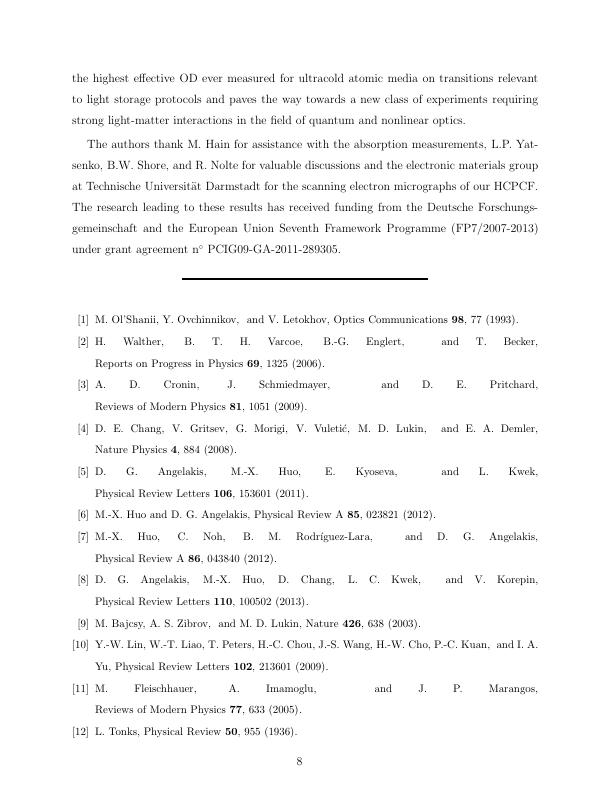

In [179]:
from IPython.display import Image as IPImage
from IPython.display import display
file_path = "./model_downloaded_pdfs/1311.0635v2.pdf"
base64_image = pdf_page_to_base64(file_path, 8)
display(IPImage(data=base64.b64decode(base64_image)))

In [191]:
run_agent(f"Search about dog images", "")

('I found several resources where you can access a large collection of dog images for free. Here are some of the top results:\n\n1. **Pixabay**: Offers over 53,327 free images of dogs, including various categories like animal, pet, nature, and cute dog portraits. You can download these images in HD for free. [Pixabay - Dog Images](https://pixabay.com/images/search/dog/)\n\n2. **FreeImages**: Provides 6,325 free dog images and pictures suitable for personal or commercial use. [FreeImages - Dog Stock Photos](https://www.freeimages.com/search/dog)\n\n3. **Dogs in Pictures**: A collection of dog photography, posters, art prints, and clip-art images from around the world. [Dogs in Pictures](https://www.dogsinpictures.com/)\n\n4. **Vecteezy**: Features 210,872 beautiful dog stock images, photos, and wallpaper available for royalty-free download. [Vecteezy - Dog Stock Photos](https://www.vecteezy.com/free-photos/dog)\n\n5. **Dreamstime**: Offers a large selection of dog stock photos and image

In [187]:
print(raw_answer)

I'm unable to view or interpret images directly. However, if you can describe the content of the image, I'd be happy to help answer any questions you have about it.
